## Practical T-tests in Large Online Experiments

**The 2 sample t-test tests for a significant difference of a variable between 2 groups.**

This notebook will grow through an example of Welch's 2 sample t-test, which assumes unequal variances between the 2 samples.

Suppose we are testing whether a new website design for our company to see if it loads signficantly faster for users when the website is used in production. Based on our setup, we would have 2 groups:

1. Treatment Group: the new version of the website
2. Control Group: the old version of the website

Since we are comparing the difference in average load times between the two groups, this is a good setup for the 2-sample t-test! Let's do one from scratch, and I'll show the practical way to do this test afterwards.

To run this experiment, we would:
1. Set our null and alternative hypotheses
2. Randomly assign a user to the new or old version of the website
3. Record their average website load time
4. Calculate the t-statistic T
5. Calculate p-values and confidence intervals and reject of fail to reject the null hypothesis


### Step 1: Set our hypotheses

Before we run our experiment, we need to have some hypotheses first to make conclusions about which website design is faster. We define our null and alternative hypotheses as follows:

Null: $\mu_{T} = \mu_{C}$. There is no significant difference in the average load time between the new and old websites.  
Alternative: $\mu_{T} \neq \mu_{C}$. The average load time for the new website is significantly different than the old website. 

### Step 2+3: Collecting the Data

This data is simulated, but let's assume the new design loads 50ms faster on average. While we are experimenting, we don't know this true value.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [9]:
# Simulation of our data
np.random.seed(67)
def generate_data(N = 10000):
    """
    Simulates website average load time data for a two-group A/B test.
    
    Parameters
    ----------
    N : int, optional
        Total number of users to simulate (default: 10000)
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns: user_id, treated (0=control, 1=treatment), 
        and avg_load_time (in milliseconds). Treatment group has ~50ms faster average load times.
    """
    shape, scale = 1, 500

    avg_load_time = np.random.gamma(shape, scale, N) 
    treated = np.random.choice([0,1], size = N, replace = True) # 1 if new website 0 if old
    user_id = np.arange(N)

    d = {
        'user_id' : user_id,
        'treated' : treated,
        'avg_load_time' : avg_load_time
    }

    data = pd.DataFrame(data = d)

    n_treated = (data['treated'] == 1).sum()
    data.loc[data['treated'] == 1, 'avg_load_time'] = np.maximum(data.loc[data['treated'] == 1, 'avg_load_time'] - 50 + np.random.normal(0, 0, size=n_treated), 0) # add effect of new website
    
    return data

data = generate_data()
data.head()


,user_id,treated,avg_load_time
0,0,0,394.665444
1,1,0,978.989480
2,2,1,529.010135
3,3,1,151.428123
4,4,1,0.000000


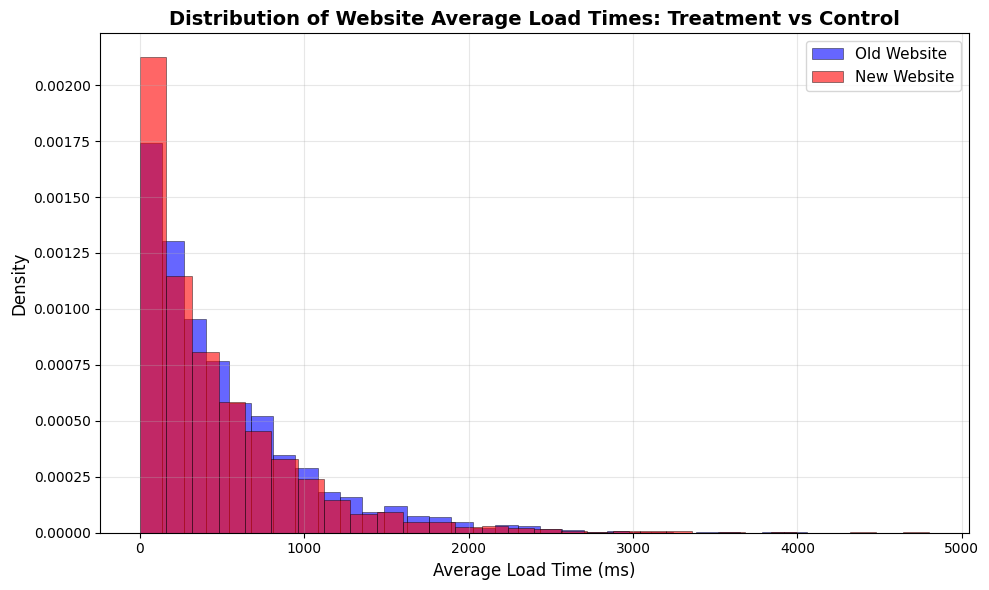

In [10]:
# Plot overlapping histograms for treated and control groups
data_fig, ax = plt.subplots(figsize=(10, 6))

# Separate data into treated and control groups
treated_data = data[data['treated'] == 1]['avg_load_time']
control_data = data[data['treated'] == 0]['avg_load_time']

# Plot both histograms on the same axes
# Use density=True so both are on the same scale
ax.hist(control_data, bins=30, alpha=0.6, color='blue', 
        edgecolor='black', linewidth=0.5, density=True, label='Old Website')
ax.hist(treated_data, bins=30, alpha=0.6, color='red', 
        edgecolor='black', linewidth=0.5, density=True, label='New Website')

# Add labels and title
ax.set_xlabel('Average Load Time (ms)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Website Average Load Times: Treatment vs Control', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Visually, it looks like the new website had faster average load times compared to the old one. But to make sure it wasn't just by chance, we run a 2 sample t-test.

### Step 3: Calculate the t-statistic

To translate the problem into math, we define the following terms: 
- $Y_T$: the average load time for a user that was shown the new design (treated)
- $Y_C$: the average load time for a user that was shown the old design (control)  
- $\Delta$: $Y_T-Y_C$. The sample difference in the average load time between the treated and control group
- $S^2_T$ : the sample variance of average load times for the treated group
- $S^2_C$ : the sample variance of average load times for the control group

The t-statistic is calculated by doing:

$$
\begin{aligned}
T &= \frac{\Delta - 0}{\sqrt{Var(\Delta)}}
\end{aligned}
$$

It looks complicated, but we are just standardizing $\Delta$ by subtracting the mean difference in average load times (under the null hypothesis) and dividing by the standard deviation of $\Delta$.

To calculate the standard deviation, $Var(\Delta) = \frac{S_T^2}{n_T} + \frac{S_C^2}{n_C}$

In [11]:
# Calculate t-statistic
treated_data = data[data['treated'] == 1]['avg_load_time']
control_data = data[data['treated'] == 0]['avg_load_time']
n_t = treated_data.shape[0]
n_c = control_data.shape[0]
N = data.shape[0] 

delta =  treated_data.mean() - control_data.mean()

variance_delta = (treated_data.var() / n_t) + (control_data.var() / n_c)

T = delta / np.sqrt(variance_delta)
print(f"Estimated difference in average load times: {delta:.2f} ms")
print(f"T statistic: {T:.2f}")

Estimated difference in average load times: -61.90 ms
T statistic: -6.07


Our estimated difference is close to the true value of -55 ms! Since we don't know this true value in practice, let's try to figure out whether the difference in average load times we observed was due to random chance or if it is a significant difference.

### Step 4: Calculate the p-value and confidence intervals and interpret them

Based on our alternative hypothesis ($\mu_T \neq \mu_C$), we are only interested in the chances we received the observed difference in average load times or something more extreme in any direction (a positive or negative effect).

Technically, this t-statistic that we calculated follows a t-distribution with n-2 degrees of freedom, but you'll often see authors of online experimentation books say that the t-statistic follows a normal distribution. This is a mathematically correct simplification because **in large sample sizes, the t-distribution converges to a normal distribution** (scroll down to the t-distribution and normal distribution section to learn about why this is the case).

Let's calculate the p-value and confidence intervals using the t-distribution to be explicit. I'll show later on how using the normal distribution gets the same results.


In [12]:
# Calculate p-value
p_value = 2 * stats.t.cdf(T, df = N-2) 
print(f"P-value: {p_value}")

P-value: 1.3464993265570102e-09


This p-value is practically 0, meaning that the probability that we observed the difference in average load times or something more extreme in the negative direction, assumming the null hypothesis is true is 0.

Therefore, we can conclude that the new website design is loads significantly faster than the old one.

We can also do this by computing confidence intervals.

In [13]:
# Calculate confidence intervals
lower_bound = delta - (stats.t.ppf(0.025, df = N-2) * np.sqrt(variance_delta))
upper_bound = delta + (stats.t.ppf(0.025, df = N-2) * np.sqrt(variance_delta))
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

95% Confidence Interval: [-41.91, -81.90]


This interval means that we are 95% confident that the true average difference in average load times in this interval. Since it does not contain 0, we have the same conclusion that we got from calculating the p-value.

### Practical Implementation

We just did the manual calculations to show how the 2 sample t-test works under the hood, but that is tedious! Here is the practical implementation using statsmodels:

In [14]:
# Perform Welch's t-test (unequal variances)
test_result = stats.ttest_ind(
    treated_data,
    control_data,
    equal_var=False,        # Variances are not equal
)

# Get the 95% confidence interval for the difference in means
ci = test_result.confidence_interval(confidence_level=0.95)

# Print the bare-bones output
print(f"P-value: {test_result.pvalue}")
print(f"95% Confidence Interval:: [{ci.low:.2f}, {ci.high:.2f}]")

P-value: 1.3466143522895037e-09
95% Confidence Interval:: [-81.90, -41.91]


As you can see, the results we get from using `scipy` matches our from scratch implementation! That's it for our example, now I'll go over some common questions about this t-tests.

### Why people use the normal distribution instead of the t-distribution for t-tests?

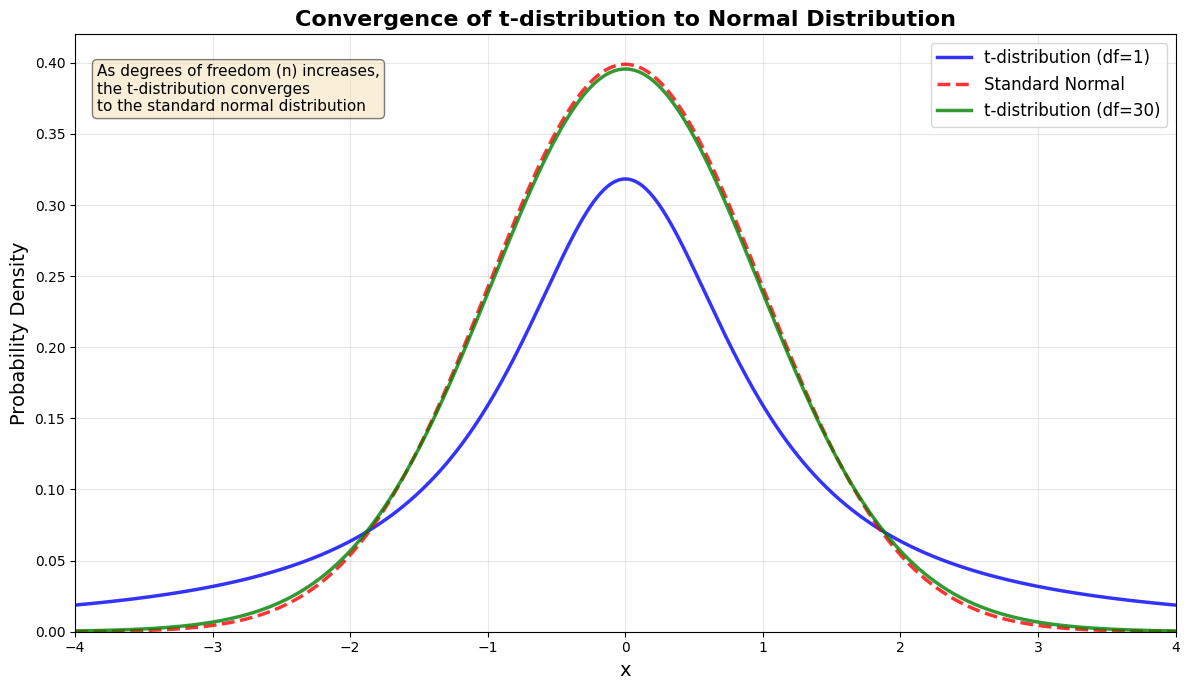

In [15]:
# Create a range of x values for plotting
x = np.linspace(-4, 4, 1000)

# Define degrees of freedom
df_small = 1  
df_large = 30  

# Calculate PDFs
t_small = stats.t.pdf(x, df=df_small)  # t-distribution with small df
normal = stats.norm.pdf(x, 0, 1)  # Standard normal distribution
t_large = stats.t.pdf(x, df=df_large)  # t-distribution with large df

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot all three distributions
ax.plot(x, t_small, 'b-', linewidth=2.5, label=f't-distribution (df={df_small})', alpha=0.8)
ax.plot(x, normal, 'r--', linewidth=2.5, label='Standard Normal', alpha=0.8)
ax.plot(x, t_large, 'g-', linewidth=2.5, label=f't-distribution (df={df_large})', alpha=0.8)

# Add labels and title
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.set_title('Convergence of t-distribution to Normal Distribution', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim(-4, 4)
ax.set_ylim(0, 0.42)

# Add annotation explaining convergence
ax.text(0.02, 0.95, 
        'As degrees of freedom (n) increases,\nthe t-distribution converges\nto the standard normal distribution',
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

As we can see, when the degrees of freedom to go about 30, the t-distribution pretty much looks the same as the normal. That is why in experimentation textbooks such as *Trustworth Online Controlled Experiments*, the authors say that the T statistic is normally distributed. It's a practical and mathematically corrects simplification when we have large samples.

### What are the assumptions of the 2 sample t-test?

For Welch's t-test, **the 2 main assumption we should worry about are independence and normality.** 

Independence has two parts. The first part is that the average load time of user A should not be affected by other users. The second part is that the observations in the treatment and control group are independent of each other. For example if user A was shown both the new and old website design, then this assumption would be violated.

Normality does **not** mean that the data from our 2 samples is normally distributed. That's often not the case! For example, the average load times were not normally distributed. We are actually assuming that **the distribution of the difference in sample means $\bar{Y_1} - \bar{Y_2}$ should be normally distributed.**

In practice, online experiments tend to have thousands of users, so by the Central Limit Theorem, the distribution of the difference in sample means will be normally distributed.

Let's look at our original data again.

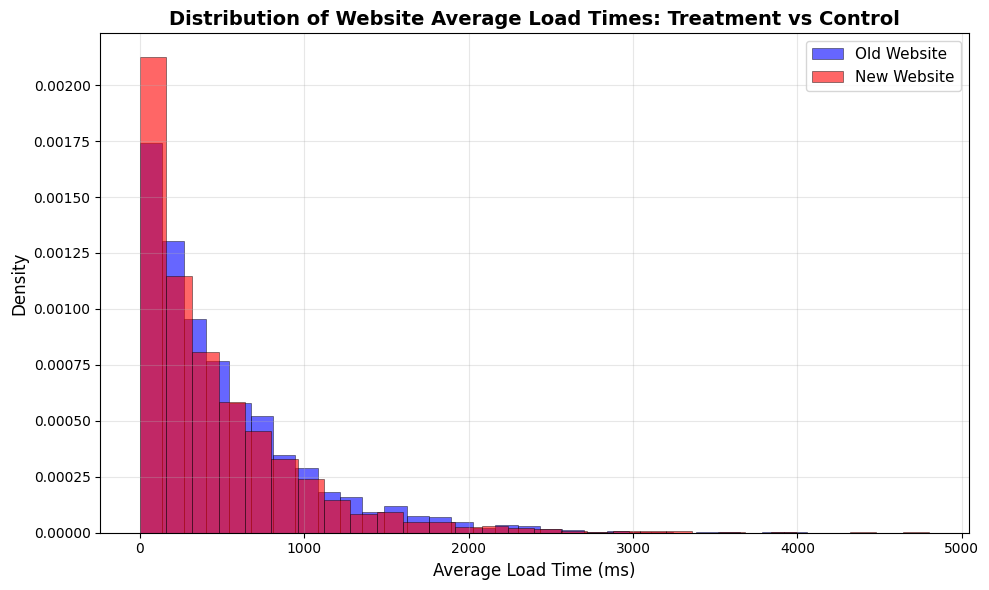

In [16]:
data_fig

This is definitely not normally distributed, yet we can still use the t-test because the difference in mean average load times of the two samples is approximately normally distributed by the CLT. The code below generates the average load time data repeatedly, calculates the sample difference in average load times, and plots it on a histogram which represents the distribution of the sample difference.

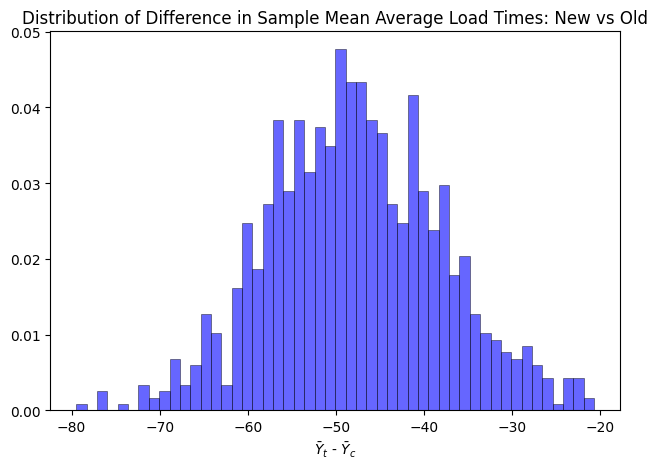

In [17]:
# Shows how the CLT fulfills the normality assumption
sample_differences = []
for i in range(1000):
    d = generate_data()

    treated_mean = d[d['treated'] == 1]['avg_load_time'].mean()
    control_mean = d[d['treated'] == 0]['avg_load_time'].mean()

    sample_differences.append(treated_mean - control_mean)


clt_fig, clt_ax = plt.subplots()


clt_ax.hist(sample_differences, bins=50, alpha=0.6, color='blue', 
        edgecolor='black', linewidth=0.5, density=True);

clt_ax.set_title('Distribution of Difference in Sample Mean Average Load Times: New vs Old')
clt_ax.set_xlabel(fr'$\bar Y_t$ - $\bar Y_c$')

plt.tight_layout()
plt.show()


**Takehome message:** Even if the distribution of your two samples is non-normal, you can stil run a t-test as long as the sample difference in means is approximately normal. This is usually fulfilled by the CLT as long as your sample size is large enough. 

But how large is large enough? You might have learned that $n \ge 30$ is usually enough for the CLT to apply, but finding the correct sample size depends on the skewness of the data. A rule of thumb when the skewness coefficient $s$ is greater than 1 in magnitude $(|s| > 1)$ is the minimum number of sample for each variant for $\bar{Y}$ to be normally distributed is $355s^2$ (Kohavi, Deng et al 2014). 

$$
\begin{aligned}
s &= \frac{[E(Y - E(Y)]^3}{[Var(Y)]^\frac{3}{2}}
\end{aligned}
$$

Let's try to estimate the sample size we need to have the CLT apply with the data we have. Since we don't know the skewness parameter $s$ of the population, we estimate it by computing $\hat{s}$. Luckily, `scipy` has a command that calculates the skew for us.


In [47]:
# Estimate s
Y = data['avg_load_time']

s_hat = stats.skew(Y)

print(f"Estimated skew coefficient: {s_hat:.2f}")

# Minimum sample size per variant: 355 * s^2 (Kohavi et al. 2014)
min_samples = 355 * np.power(s_hat, 2)
print(f"Minimum samples needed per group: {np.ceil(min_samples)}")


Estimated skew coefficient: 2.02
Minimum samples needed per group: 1455.0


So we need at least 1455 people in each group for the normality assumption to hold. In practice, we would only use this number check if we suspect that our metric is skewed.

### Why didn't you mention the equal variances assumption? Why did you only cover Welch's t-test?

Welch's t-test doesn't assume anything about equal variances (the pooled t-test does)! I only covered Welch's t-test becuase it is generally more robust. [It will work when the variances are equal or not, with no substantial disadvantages to the pooled t-test](https://bpspsychub.onlinelibrary.wiley.com/doi/10.1348/000711004849222). With the large sample sizes in online experiments, it's fine to default to Welch's t-test for robustness.